In [1]:
import zarr
import numpy as np


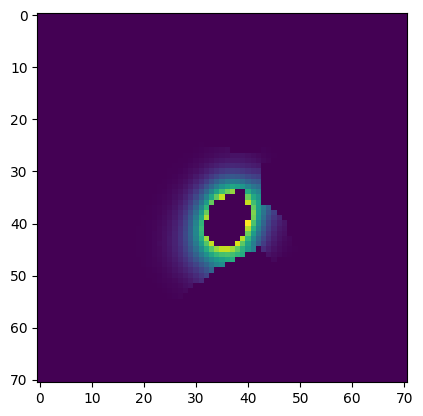

In [2]:
import zarr
import matplotlib.pyplot as plt

# Open the Zarr dataset
dataset = zarr.open('/Users/schaff/Documents/workspace/vcell/pythonData/test_data/zarr/', mode='r')

# Get a slice of the dataset
slice = dataset[3, 2, 5, :, :]

# Display the slice as an image
plt.imshow(slice)
plt.show()